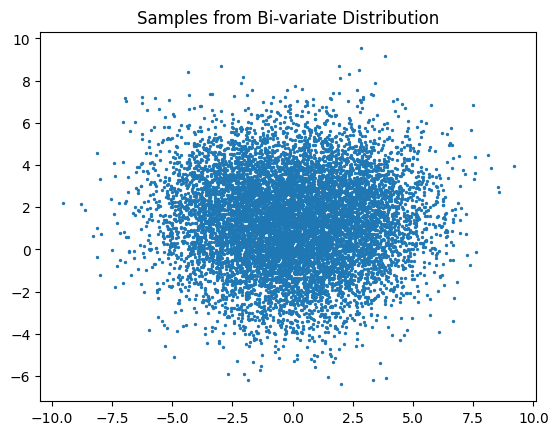

Epoch [1/100], Loss D: 0.9888604879379272, Loss G: 0.6371390223503113
Epoch [2/100], Loss D: 1.059232473373413, Loss G: 0.84621262550354
Epoch [3/100], Loss D: 1.2797797918319702, Loss G: 0.8496732711791992
Epoch [4/100], Loss D: 1.2208647727966309, Loss G: 0.8812666535377502
Epoch [5/100], Loss D: 1.2966203689575195, Loss G: 1.0168538093566895
Epoch [6/100], Loss D: 1.184192419052124, Loss G: 0.9485790729522705
Epoch [7/100], Loss D: 1.5664761066436768, Loss G: 0.7861980199813843
Epoch [8/100], Loss D: 1.492560863494873, Loss G: 0.8729035258293152
Epoch [9/100], Loss D: 1.526015043258667, Loss G: 0.7801167368888855
Epoch [10/100], Loss D: 1.386786699295044, Loss G: 0.7700973749160767
Epoch [11/100], Loss D: 1.3960487842559814, Loss G: 0.6803786754608154
Epoch [12/100], Loss D: 1.3830562829971313, Loss G: 0.735285758972168
Epoch [13/100], Loss D: 1.4122895002365112, Loss G: 0.7500652074813843
Epoch [14/100], Loss D: 1.3843777179718018, Loss G: 0.7127428650856018
Epoch [15/100], Loss D:

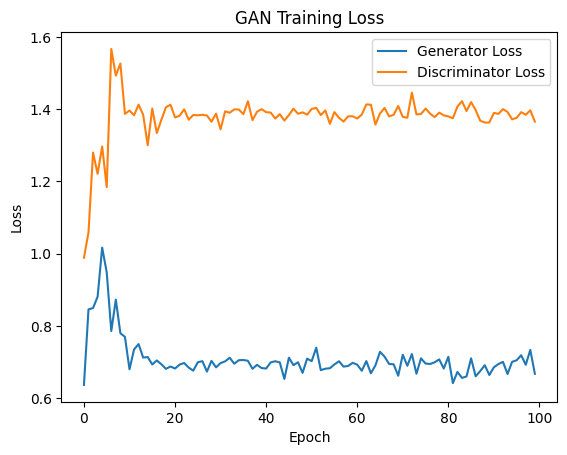

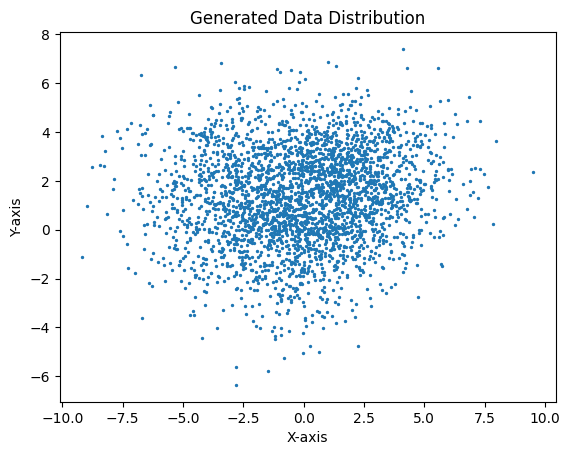

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

mu1 = np.array([0, 0])
mu2 = np.array([2, 2])
mu3 = np.array([-2, 2])
sigma = 2

num_samples = 10000
z_samples = np.random.normal(mu1, sigma, size=(num_samples // 3, 2))
z_samples = np.concatenate([z_samples, np.random.normal(mu2, sigma, size=(num_samples // 3, 2))])
z_samples = np.concatenate([z_samples, np.random.normal(mu3, sigma, size=(num_samples // 3, 2))])
np.random.shuffle(z_samples)
z_samples_tensor = torch.tensor(z_samples, dtype=torch.float32)


plt.scatter(z_samples_tensor[:, 0], z_samples_tensor[:, 1], s=2)
plt.title("Samples from Bi-variate Distribution")
plt.show()

# Define Generator and Discriminator architectures
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

num_epochs = 100
batch_size = 64
losses_generator = []
losses_discriminator = []


dataset = TensorDataset(z_samples_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch in data_loader:
        batch_size = batch[0].size(0) 

        z_batch = torch.randn(batch_size, 2)
        generated_samples = generator(z_batch)

        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        real_predictions = discriminator(batch[0])
        fake_predictions = discriminator(generated_samples.detach())

        real_loss = criterion(real_predictions, real_labels)
        fake_loss = criterion(fake_predictions, fake_labels)
        discriminator_loss = real_loss + fake_loss

        discriminator_loss.backward()
        optimizer_d.step()

        generator.zero_grad()
        z_batch = torch.randn(batch_size, 2)
        generated_samples = generator(z_batch)
        generator_predictions = discriminator(generated_samples)

        generator_loss = criterion(generator_predictions, real_labels)
        generator_loss.backward()
        optimizer_g.step()

    losses_generator.append(generator_loss.item())
    losses_discriminator.append(discriminator_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {discriminator_loss.item()}, Loss G: {generator_loss.item()}')

# Plot the Loss vs Epoch curve
plt.plot(losses_generator, label='Generator Loss')
plt.plot(losses_discriminator, label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.show()


# Generate 3000 points from the trained GAN generator
num_generated_points = 3000
generated_data = []
with torch.no_grad():
    for _ in range(num_generated_points // batch_size):
        z_batch = torch.randn(batch_size, 2)
        generated_batch = generator(z_batch).numpy()
        generated_data.append(generated_batch)

generated_data = np.concatenate(generated_data)


plt.scatter(generated_data[:, 0], generated_data[:, 1],s=2)
plt.title('Generated Data Distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


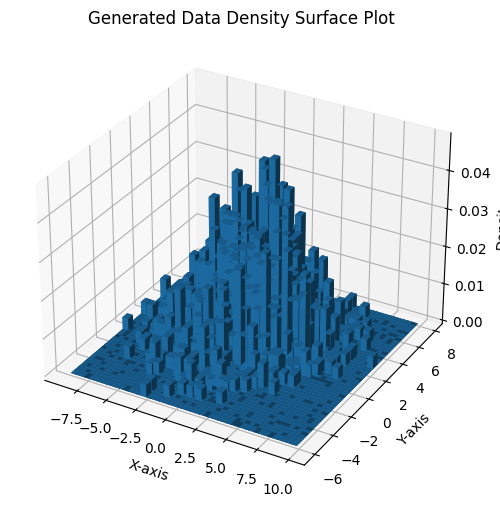

In [10]:
from mpl_toolkits.mplot3d import Axes3D

hist, xedges, yedges = np.histogram2d(generated_data[:, 0], generated_data[:, 1], bins=50, density=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, cmap='viridis')

ax.set_title('Generated Data Density Surface Plot')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Density')

plt.show()


# Observations

- The distribution generated by GAN is almost similar to the distribution of training data.

- These peaks indicate that the generator has learned to produce data points that match the clusters present in the original distribution.

- In cases where the GAN struggles or hasn't adequately captured the distribution, you might observe fewer peaks than expected or significant mixing between modes. 